In [1]:
import numpy as np
import sep

from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = [10., 8.]

In [2]:
#opens the file
hdu = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')

In [3]:
hdu.info()

Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   (3600, 3600)   float32   


In [4]:
data = hdu[0].data

before doing the other steps, we redo the tutorial to give us the image

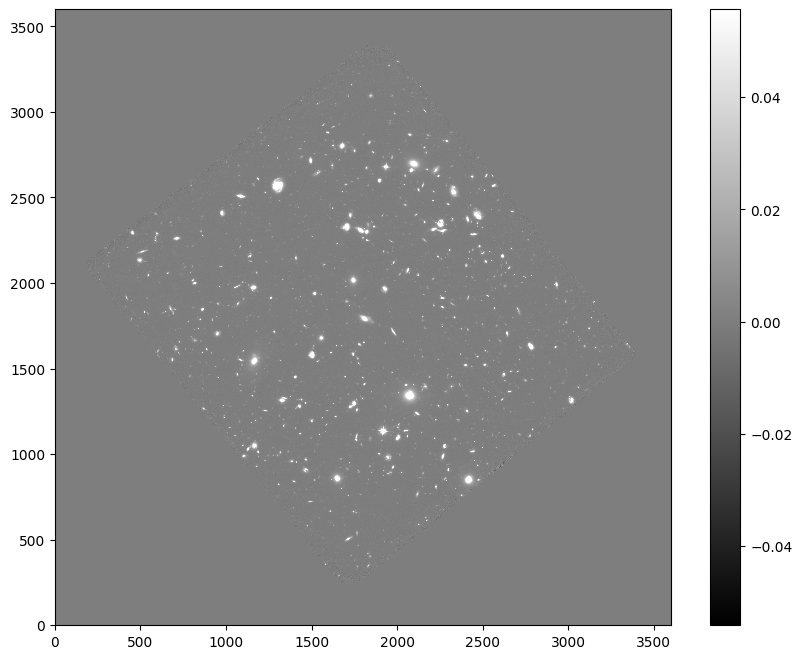

In [5]:
#shows the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig(('image_picture.png'), bbox_inches="tight")

now that we have the orginal image, we evalute the background and the backgground noise from the data

In [6]:
data = data.astype(data.dtype.newbyteorder('='))
#measures spatially varying bg of image
bkg = sep.Background(data, bw=64, bh=64, fw=3, fh=3)

In [7]:
#get a global mean and noise
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [8]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

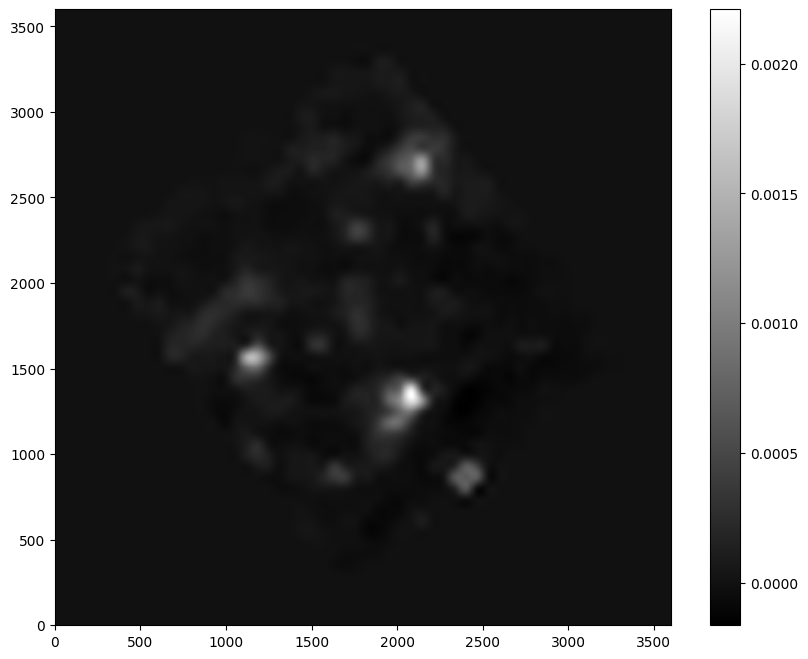

In [9]:
#show bg
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig(('background.png'), bbox_inches="tight")

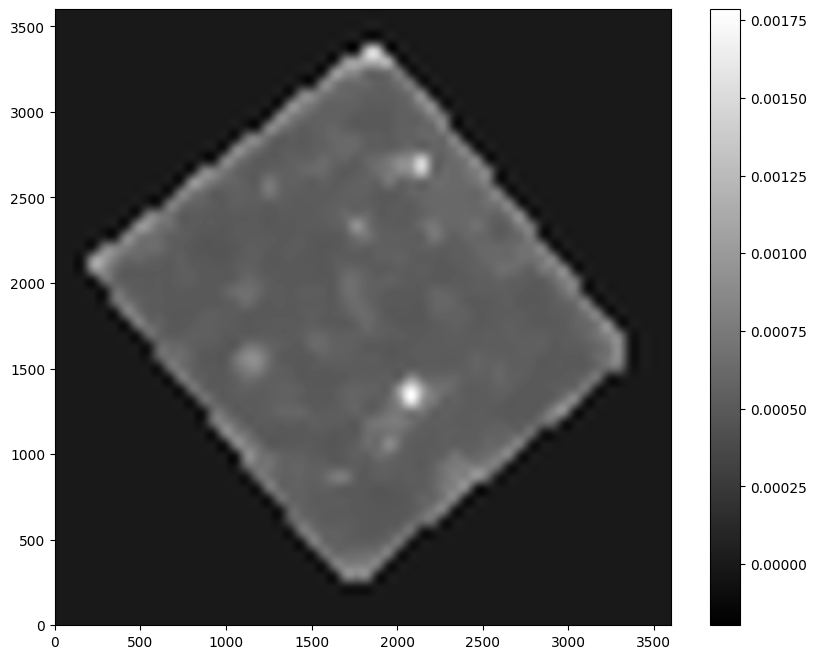

In [10]:
bkg_rms = bkg.rms()
#show background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig(('background_noise.png'), bbox_inches="tight")

In [11]:
#subtract bg
data_sub = data - bkg

In [12]:
objects = sep.extract(data_sub, 5, err=bkg.globalrms)

we now detect the amount of objects in the image within our set threshold using programed ellipses

In [13]:
#how many objects are in the image
len(objects)

2633

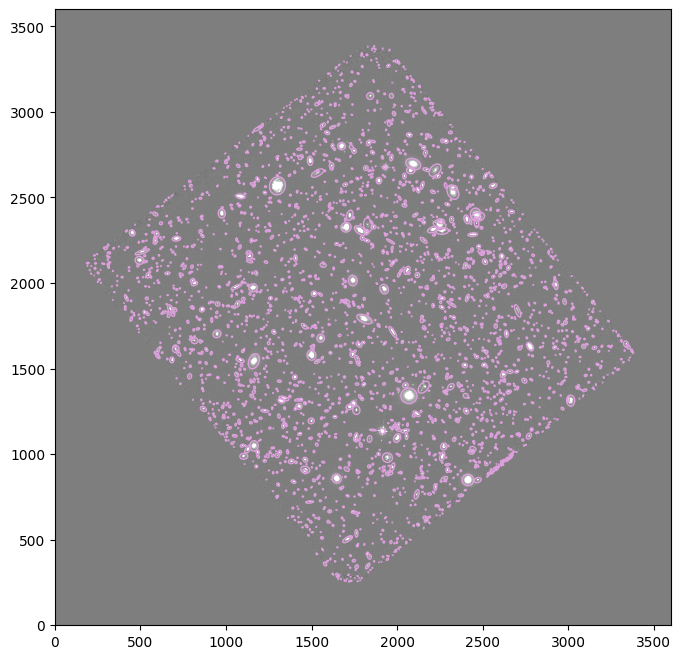

In [14]:
from matplotlib.patches import Ellipse

#plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

#plot an ellipse for each object fro detection
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('plum')
    ax.add_artist(e)

In [15]:
#shows fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

flux correlates to the brightness of an object

In [16]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

In [17]:
#shows the flux for the amount of objects found
for i in range(2633):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.029248 +/- 0.171045
object 1: flux = 0.081285 +/- 0.285120
object 2: flux = 0.062260 +/- 0.249537
object 3: flux = 0.069449 +/- 0.263548
object 4: flux = 0.039489 +/- 0.198739
object 5: flux = 0.104682 +/- 0.323559
object 6: flux = 0.040038 +/- 0.200116
object 7: flux = 0.053010 +/- 0.230257
object 8: flux = 0.053288 +/- 0.230859
object 9: flux = 0.042534 +/- 0.206259
object 10: flux = 0.032401 +/- 0.180026
object 11: flux = 0.069365 +/- 0.263388
object 12: flux = 0.018837 +/- 0.137276
object 13: flux = 0.045413 +/- 0.213123
object 14: flux = 0.063251 +/- 0.251513
object 15: flux = 1.153159 +/- 1.073856
object 16: flux = 0.148081 +/- 0.384824
object 17: flux = 0.140420 +/- 0.374738
object 18: flux = 0.138712 +/- 0.372452
object 19: flux = 0.062022 +/- 0.249059
object 20: flux = 0.061034 +/- 0.247068
object 21: flux = 0.109369 +/- 0.330722
object 22: flux = 0.067484 +/- 0.259792
object 23: flux = 0.084759 +/- 0.291149
object 24: flux = 0.550249 +/- 0.741794
object 25:

now we create the histogram of this data (using log10)

/var/folders/3w/crzghqrj1198zt0qsp8bzgv80000gn/T/ipykernel_67109/138386729.py:2: RuntimeWarning: invalid value encountered in log10
  histmin = np.floor(np.log10(np.min(flux)))
/var/folders/3w/crzghqrj1198zt0qsp8bzgv80000gn/T/ipykernel_67109/138386729.py:7: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(flux), bins=100, edgecolor = 'black',facecolor = 'lightpink')


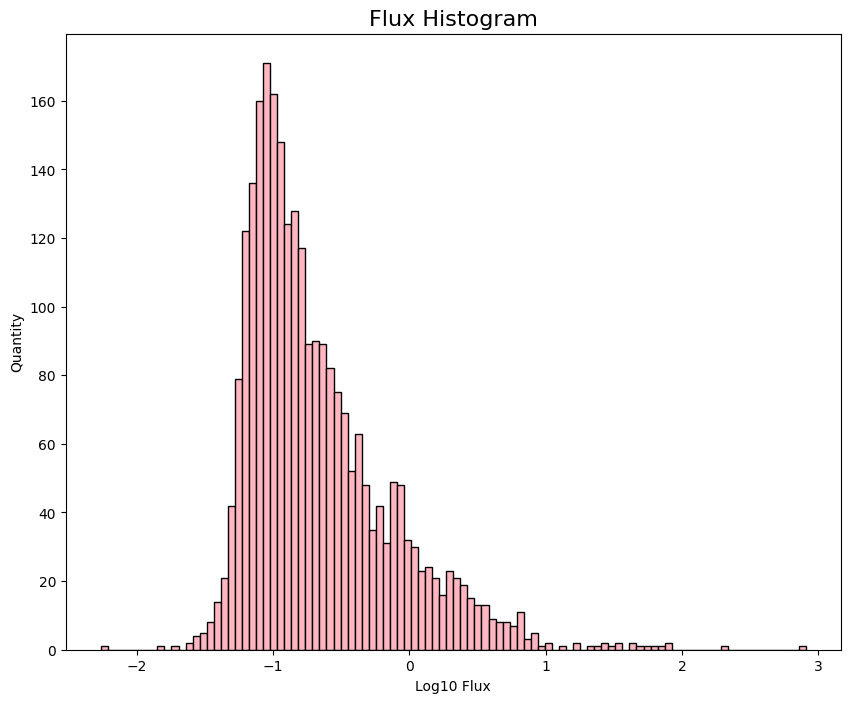

In [20]:
width = .1
histmin = np.floor(np.log10(np.min(flux)))
histmax = np.ceil(np.log10(np.max(flux)))

#bins_log = np.arange(histmin, histmax + width, width)

plt.hist(np.log10(flux), bins=100, edgecolor = 'black',facecolor = 'lightpink')

plt.title("Flux Histogram", fontsize=16,color="black")
plt.xlabel("Log10 Flux")
plt.ylabel("Quantity")

plt.savefig('flux_histo.png')
plt.show()

finding data/stats based on the graph

In [31]:
import numpy as np 
import matplotlib.pyplot as plt
from astropy.io import fits
import sep



mean_flux = np.mean(f105)
median_flux = np.median(f105)
std_flux = np.std(f105)

print("Linear Flux Stats for F105W")
print(f"Mean = {mean_flux}")
print(f"Median = {median_flux}")
print(f"Standard Deviation = {std_flux}")


Linear Flux Stats for F105W
Mean = 0.0007716763066127896
Median = 1.303368861816129e-22
Standard Deviation = 0.054863978177309036


now we find the brightest object in the image and its data!

In [22]:
max_flux = np.max(flux)

# How many standard deviations from the mean?
zscore = (max_flux - mean_flux) / std_flux

# Position of the outlier in the image
y, x = np.unravel_index(np.argmax(data), data.shape)

print("Outlier Information")
print(f"Largest Flux Value: {max_flux}")
print(f"Location in Image (x, y): ({x}, {y})")
print(f"Standard Deviations from Mean: {zscore}")

NameError: name 'mean_flux' is not defined

since we have everything, we can now begin creating an rbg image from these 3 fits files

In [23]:
hdu = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits')
hdu = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits')
hdu = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')

In [24]:
f105 = fits.getdata('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
f125 = fits.getdata('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits')
f160 = fits.getdata('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits')

find medians after subtracting the graph

In [25]:
median_f105 = np.nanmedian(f105[f105 > 0])
median_f125 = np.nanmedian(f125[f125 > 0])
median_f160 = np.nanmedian(f160[f160 > 0])

print(f'Median of F105W sky: {median_f105}')
print(f'Median of F125W sky: {median_f125}')
print(f'Median of F160W sky: {median_f160}')

Median of F105W sky: 0.0005463843117468059
Median of F125W sky: 0.0007221213891170919
Median of F160W sky: 0.0005512635107152164


In [26]:
#AttributeError: `newbyteorder` was removed from the ndarray class in NumPy 2.0. Use `arr.view(arr.dtype.newbyteorder(order))` instead.
#f105 = f105.byteswap().newbyteorder()

#tried this but it did not work
#f105 = f105.view(f105.arr.view(arr.dtype.newbyteorder(order))

#this is how we fix it for this version of numpy
f105 = f105.byteswap().view(f105.dtype.newbyteorder('='))
f125 = f125.byteswap().view(f125.dtype.newbyteorder('='))
f160 = f160.byteswap().view(f160.dtype.newbyteorder('='))


#Compute bg using SEP
bkg_f105 = sep.Background(f105)
bkg_f125 = sep.Background(f125)
bkg_f160 = sep.Background(f160)


f105 -= bkg_f105
f125 -= bkg_f125
f160 -= bkg_f160

In [27]:
median_f105 = np.nanmedian(f105[f105 > 0])
median_f125 = np.nanmedian(f125[f125 > 0])
median_f160 = np.nanmedian(f160[f160 > 0])

print(f'Median of F105W sky: {median_f105}')
print(f'Median of F125W sky: {median_f125}')
print(f'Median of F160W sky: {median_f160}')


Median of F105W sky: 2.1849032805221213e-07
Median of F125W sky: 3.119022835562646e-07
Median of F160W sky: 2.2447694902894e-07


rescaling the data for plotting

In [28]:
def rescale_data(data, dmin=0.01, dmax=10.0):
    
    clipped = np.clip(data, dmin, dmax)
    return (np.log10(clipped) - np.log10(dmin)) / (np.log10(dmax) - np.log10(dmin))


In [29]:
p_f105 = rescale_data(f105)
p_f125 = rescale_data(f125)
p_f160 = rescale_data(f160)

now we make an RBG stack and can finally see/show the data

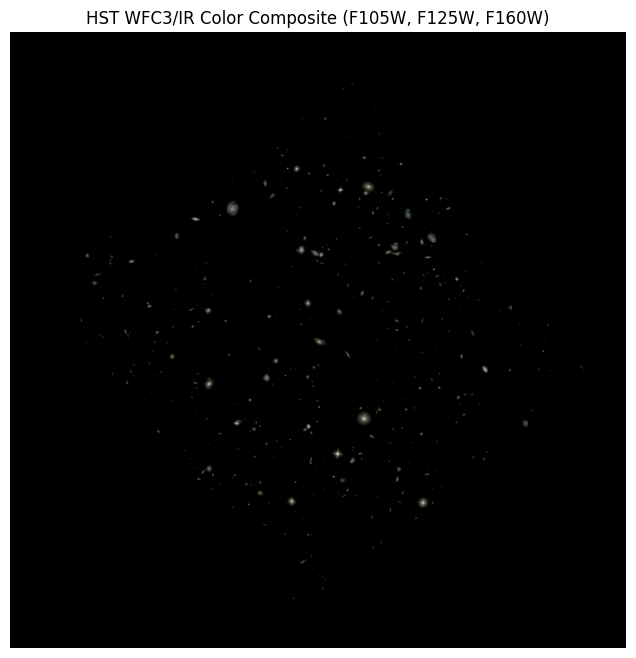

In [30]:
rgb = np.dstack((p_f160, p_f125, p_f105))

xsize = rgb.shape[1]
ysize = rgb.shape[0]
plt.figure(figsize=(8,8))
plt.imshow(rgb, origin='lower')
plt.axis('off')  # remove axis for clean image
plt.title("HST WFC3/IR Color Composite (F105W, F125W, F160W)")
plt.savefig('HST_IR_RGB.png', dpi=300, bbox_inches='tight')
plt.show()


thank you and bless lecture 15 for this information